In [3]:
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx

import matplotlib.pyplot as plt

In [4]:
# read in the data 
edges = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkEdges.csv")
nodes = pd.read_csv("https://raw.githubusercontent.com/rafaelprietocuriel/AfricanUrbanNetwork/main/AfricaNetworkNodes.csv", encoding='unicode_escape', engine ='python')

In [5]:
# make the network
G = nx.from_pandas_edgelist(edges, source='from', target='to', edge_attr = ['l', 'time', 'timeU', 'timeUCB'])

# add the node attributes
nx.set_node_attributes(G, nodes.set_index('Agglomeration_ID').to_dict('index'))

This should take 1-2 minutes, but changing the step size would speed it up if you need.

In [6]:
%%time
# we want to store the components and the length of the largest component
lengths = []
components = list()

# at each threshold, we remove the edges that are longer than the threshold
for i in np.arange(0, edges.l.max()):
    G_ = G.copy()
    _ = [G_.remove_edge(u, v) for u, v, d in G.edges(data=True) if d['l'] > i]
    
    labels = pd.DataFrame({u: i for i, n in enumerate(sorted(nx.connected_components(G_), key=len, reverse=True)) for u in n}, index=['component']).T
    labels['threshold'] = i
    labels['gcc'] = len(max(nx.connected_components(G_), key=len))
    
    lengths.append(len(max(nx.connected_components(G_), key=len)))
    components.append(labels)
    
components = pd.concat(components)
components.head()

CPU times: user 1min 35s, sys: 166 ms, total: 1min 35s
Wall time: 1min 35s


,component,threshold,gcc
8211,0,0.0,1
2333,1,0.0,1
1000559,2,0.0,1
1000567,3,0.0,1
5425,4,0.0,1


In [17]:
def clean_components(dataframe, nodes=nodes, edges=edges, steps=np.append(np.arange(10, 450, 10), 600)):
    edges_copy = edges.copy()
    nodes_copy = nodes.copy()

    components_copy = dataframe[dataframe.threshold.isin(steps)].merge(nodes_copy,
                                                                                         left_index=True, right_on='Agglomeration_ID', how='left')

    # just clean up the columns so they are all unique identifiers
    components_copy['aggnm'] = components_copy['agglosName']
    components_copy['pop15'] = components_copy['Pop2015']
    components_copy['thrno'] = components_copy['threshold']
    components_copy['thrid'] = components_copy['threshold'].astype(int).astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['comid'] = components_copy['component'].astype(str).str.pad(fillchar="0", side='left', width=7)
    components_copy['aggid'] = components_copy['Agglomeration_ID'].astype(str).str.pad(fillchar="0", side='left', width=7)

    components_copy = components_copy[['aggnm', 'pop15', 'thrno', 'thrid', 'comid', 'aggid', 'gcc', 'Agglomeration_ID']]

    # we are going to tag each component with the biggest city in it so that we can track the components over time (the component numbers are not consistent across runs)
    biggest = components_copy.sort_values('pop15', ascending=False).groupby(['thrid', 'comid'], as_index=False).first()
    biggest['biggest_rank'] = biggest.pop15.rank(ascending=False, method='dense')
    # let's all get population statistics for the biggest city in each component
    n_comps = components_copy[components_copy['aggnm']!='road'].groupby(['thrid', 'comid'], as_index=False).agg({'pop15': ['count', 'sum']})
    n_comps.columns = [''.join(x) for x in n_comps.columns]
    # merge the biggest city and the number of cities in the component
    components_copy = components_copy.merge(biggest[['thrid', 'comid', 'aggnm', 'pop15', 'biggest_rank']].rename(columns={'aggnm': 'biggest_city', 'pop15': 'biggest_pop'}), 
                                            left_on=['thrid', 'comid'], 
                                            right_on=['thrid', 'comid'], 
                                            how='left').merge(n_comps, 
                                                              left_on=['thrid', 'comid'], 
                                                              right_on=['thrid', 'comid'], 
                                                              how='left').sort_values('pop15count', ascending=False)
    
    return components_copy
    

In [18]:
components_copy = clean_components(components)

In [26]:
# africa basemap
africa = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = africa[africa['continent']=="Africa"]

In [27]:
# hacky way to make a discrete palette that looks okay
from colorcet import palette
from matplotlib import colors
pal = np.tile(palette['glasbey_light'], len(nodes) // len(palette['glasbey_light']))
pal = colors.ListedColormap(pal)

Text(143.5, 0.5, 'GCC (nodes)')

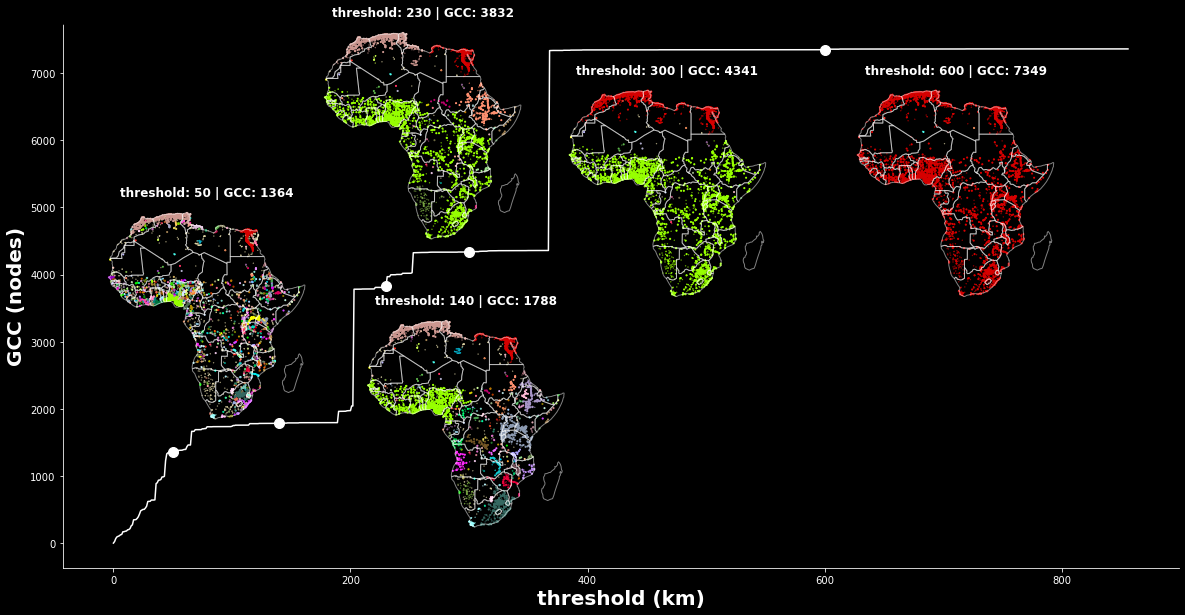

In [28]:
# we are going to show some maps, so here we specify size
size = [0.15, 0.35]
# thresholds we want maps of 
selection = [50, 140, 230, 300, 600]
# show the points of these along the curve
points = components[components.threshold.isin(selection)].groupby('threshold').first().reset_index()

fig, ax = plt.subplots(figsize=(20, 10), facecolor='k')
ax.plot(np.arange(0, edges.l.max()), lengths, color='w')

for i, j in zip(selection, [[0.15, 0.30], [0.33, 0.15], [0.30, 0.55], [0.47, 0.47], [0.67, 0.47]]):
    
    sub = plt.axes(j + size, facecolor='#000000')
    
    temp_comps = components_copy[components_copy['thrno']==i]

    g = temp_comps.gcc.iloc[0]

    temp_nodes = gpd.GeoDataFrame(nodes, geometry=gpd.points_from_xy(nodes['x'], nodes['y'], crs='epsg:4326'))
    temp_nodes = temp_nodes.merge(temp_comps, left_on='Agglomeration_ID', right_on='Agglomeration_ID')
    temp_nodes['component'] = temp_nodes['biggest_rank']
    
    temp_marks= (np.log(temp_nodes['Pop2015'] + 1) + 1) / 10
    temp_nodes.plot('component', markersize=temp_marks, cmap=pal, ax=sub)
    
    africa.plot(color='None', edgecolor='w', linewidth=1, alpha=0.5, ax=sub)
    sub.set_title(f"threshold: {i} | GCC: {temp_comps.gcc.iloc[0]}", color='w', weight='bold')
    sub.set_axis_off()
    
ax.scatter(points.threshold.to_numpy(), points.gcc.to_numpy(), s=100, c='w')

ax.set_facecolor('k')

ax.spines["bottom"].set_color("w")
ax.spines["left"].set_color("w")

font = {'weight':'bold', 'alpha':1.0, 'size':20}

ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

ax.set_xlabel("threshold (km)", color="w", fontdict=font)
ax.set_ylabel("GCC (nodes)", color="w", fontdict=font)